In [1]:
import torch
import argparse
from dataloader import RGBDepthPano

from image_encoders import RGBEncoder, DepthEncoder
from TRM_net import BinaryDistPredictor_TRM, TRM_predict

from eval import waypoint_eval
import math
import os
import glob
import utils
import random
from utils import nms
from utils import print_progress
from tensorboardX import SummaryWriter

import numpy as np
from gen_training_data.utils import Simulator
from test_gtmap import create_simulator
import draw
from habitat.utils.visualizations import maps as habitat_maps
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import quaternion

BATCH_SIZE = 1
NUM_IMGS = 12
ANGLES = 120
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eval_img_dir = './training_data/rgbd_fov90/val_unseen/*/*.pkl'  # Evaluation image directory
nav_dict_path = './training_data/%s_*_mp3d_waypoint_twm0.2_obstacle_first_withpos.json'%(ANGLES)
navigability_dict = utils.load_gt_navigability(nav_dict_path)
evaldataloader = RGBDepthPano(NUM_IMGS, eval_img_dir, navigability_dict)  # Evaluation data loader
evalloader = torch.utils.data.DataLoader(evaldataloader, 
        batch_size=BATCH_SIZE, shuffle=False, num_workers=4) 
raw_graph_data = {}

for split in ['train', 'val_unseen']:
    path = f'./data/adapted_mp3d_connectivity_graphs/{split}.json'
    with open(path) as f:
        data = json.load(f)
        raw_graph_data.update(data) 

In [2]:
for idx in range(evaldataloader.__len__()):
    # if 'EU6Fwq7SyZv' in evaldataloader.img_dirs[idx] and 'ef6ef26f03364dd897ca5f93fbeeeee8' in evaldataloader.img_dirs[idx]:
    if '2azQ1b91cZZ' in evaldataloader.img_dirs[idx] and 'c14db1c9fdcb4f96b202b49a91c45f14' in evaldataloader.img_dirs[idx]:
        print(idx)
        break

119


In [3]:
iter_loader = iter(evalloader)
for t in range(idx+1):
    data = next(iter_loader)
# data = next(iter(evalloader))
scan_ids = data['scan_id']
waypoint_ids = data['waypoint_id']
sample_id = data['sample_id']
rgb_imgs = data['rgb'].to(device)
depth_imgs = data['depth'].to(device)

target, obstacle, weight, \
source_pos, target_pos = utils.get_gt_nav_map(
            ANGLES, navigability_dict, scan_ids, waypoint_ids)

target = target.to(device)
obstacle = obstacle.to(device)
weight = weight.to(device)

In [ ]:
cur_scan_id, waypoint_id
# 120 ('2azQ1b91cZZ', 'c14db1c9fdcb4f96b202b49a91c45f14') balcony

('2azQ1b91cZZ', 'c14db1c9fdcb4f96b202b49a91c45f14')

In [42]:
sim.close()

I0612 14:04:16.784691 1505090 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0612 14:04:16.784739 1505090 SemanticScene.h:43] Deconstructing SemanticScene
I0612 14:04:16.788527 1505090 SceneManager.h:25] Deconstructing SceneManager
I0612 14:04:16.788532 1505090 SceneGraph.h:25] Deconstructing SceneGraph
I0612 14:04:16.789021 1505090 Sensor.cpp:69] Deconstructing Sensor
I0612 14:04:16.789136 1505090 Sensor.cpp:69] Deconstructing Sensor
I0612 14:04:16.795682 1505090 Renderer.cpp:71] Deconstructing Renderer
I0612 14:04:16.795689 1505090 WindowlessContext.h:17] Deconstructing WindowlessContext


2025-06-13 10:19:10,483 initializing sim Sim-v1
I0613 10:19:10.486785 1715445 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I0613 10:19:10.486801 1715445 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I0613 10:19:10.486845 1715445 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I0613 10:19:10.486864 1715445 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
I0613 10:19:10.486881 1715445 AssetAttributesManager.cpp:120] Asset attributes (coneSolid : coneSolid_segment

Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.144.03
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


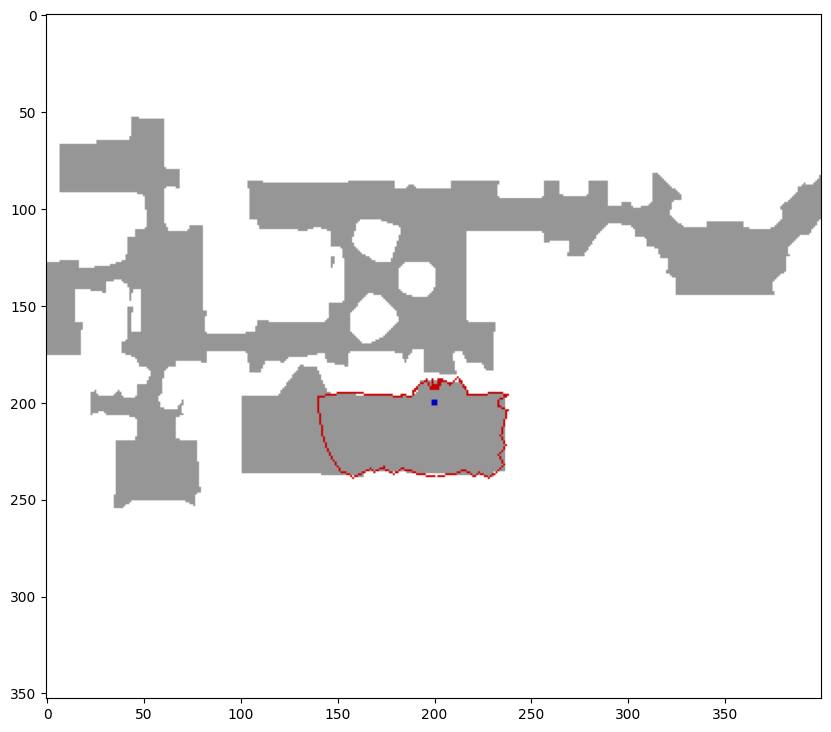

In [4]:
cur_scan_id = scan_ids[0]
waypoint_id = waypoint_ids[0]
config_path = 'gen_training_data/config.yaml'
scene_path = './data/scene_datasets/mp3d/{scan}/{scan}.glb'
sim = create_simulator(config_path, scene_path, cur_scan_id)
cur_obstacle = obstacle[0].cpu().numpy()
cur_source_pos = source_pos[0]
current_heading = 0.0
obstacle_radial = draw.get_obstacles_from_radial_map(cur_obstacle, 120, 12)
last_pos_index = None

node_height = raw_graph_data[cur_scan_id]['nodes'][waypoint_id][1]
top_down_map = draw.get_top_down_map(sim, base_height=node_height)
source_pos_index = habitat_maps.to_grid(cur_source_pos[1], cur_source_pos[0], top_down_map.shape[0:2], sim)
draw.draw_source_new(top_down_map, cur_source_pos, 0.05, sim)
for r, theta in obstacle_radial:
    pos = draw._rtheta_to_global_coordinates(r, theta, cur_source_pos, current_heading)
    pos_index = habitat_maps.to_grid(pos[1], pos[0], top_down_map.shape[0:2], sim)
    if last_pos_index != None:
        draw.drawline(top_down_map, [last_pos_index[1], last_pos_index[0]], [pos_index[1], pos_index[0]], thickness=1, style="filled", color=6 ,gap=1)
    #draw.draw_obstacle_new(top_down_map_2, pos, 0.05, sim)
    last_pos_index = pos_index
color_map = draw.colorize_topdown_map(top_down_map)
crop_image = draw.crop_around_point(color_map, source_pos_index[0], source_pos_index[1], padding=200)
# sim.close()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(crop_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


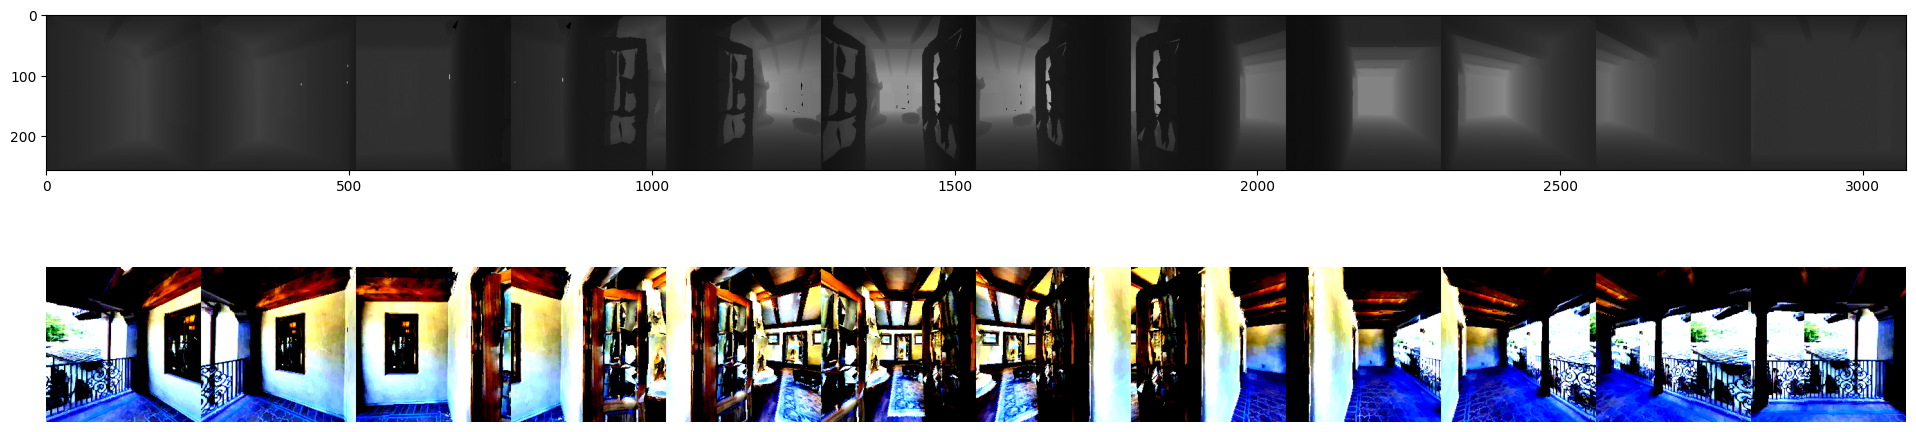

In [5]:
n_rows = 2
n_cols = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 6))
panorama_d = np.concatenate(depth_imgs[0].cpu().numpy(), axis=1)
panorama_d = np.fliplr(panorama_d)  # Flip depth panorama horizontally
axes[0].imshow(panorama_d, cmap='gray')  # or 'gray', 'viridis', etc.
panorama_rgb = np.concatenate(rgb_imgs[0].cpu().numpy().transpose(0,2,3,1), axis=1)
panorama_rgb = np.fliplr(panorama_rgb)
axes[1].imshow(panorama_rgb)  # Display RGB panorama
# plt.colorbar(label='Depth (m)')
# plt.title("Depth Image")
plt.axis('off')
plt.show()

In [6]:
import open3d as o3d
def build_full_scene_pcd(depth, hfov):
    height, width = depth.shape

    cx = (width - 1.) / 2.
    cy = (height - 1.) / 2.
    fx = (width / 2.) / np.tan(np.deg2rad(hfov / 2.))
    # fy = (height / 2.) / np.tan(np.deg2rad(self.args.hfov / 2.))

    x = np.arange(0, width, 1.0)
    y = np.arange(0, height, 1.0)
    u, v = np.meshgrid(x, y)
    
    # Apply the mask, and unprojection is done only on the valid points
    valid_mask = depth > 0
    masked_depth = depth[valid_mask]
    u = u[valid_mask]
    v = v[valid_mask]

    # Convert to 3D coordinates
    x = (u - cx) * masked_depth / fx
    y = (v - cy) * masked_depth / fx
    z = masked_depth

    # Stack x, y, z coordinates into a 3D point cloud
    points = np.stack((x, y, z), axis=-1)
    points = points.reshape(-1, 3)
    
    # Perturb the points a bit to avoid colinearity
    points += np.random.normal(0, 4e-3, points.shape)

    color_mask = np.repeat(valid_mask[:, :, np.newaxis], 3, axis=2)
    # image_flat = image[color_mask].reshape(-1, 3)  # Flatten the image array for easier indexing
    # colors = image_flat / 255.0  # Normalize the colors
    
    # TODO: we can get per pixel label for stair here as well.

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    # pcd.colors = o3d.utility.Vector3dVector(colors)
    
    camera_object_pcd = pcd.voxel_down_sample(0.05)

    return camera_object_pcd

def get_transform_matrices(sensor_position, sensor_rotation, init_sim_position, init_sim_rotation):
    """
    transform the habitat-lab space to Open3D space (initial pose in habitat)
    habitat-lab space need to rotate camera from x,y,z to  x, -y, -z
    Returns Pose_diff, R_diff change of the agent relative to the initial timestep
    """


    camera_position = sensor_position#agent_state.sensor_states["depth_90"].position
    camera_rotation = quaternion.as_rotation_matrix(sensor_rotation)#agent_state.sensor_states["depth_90"].rotation)

    h_camera_matrix = np.eye(4)
    h_camera_matrix[:3, :3] = camera_rotation
    h_camera_matrix[:3, 3] = camera_position

    habitat_camera_self = np.eye(4)
    habitat_camera_self[:3, :3] = np.array([[1, 0, 0],
                [0, -1, 0],
                [0, 0, -1]])
    habitat_camera_self_aj = np.eye(4)
    habitat_camera_self_aj[:3, :3] = np.array([[0, 0, -1],
                [0, 1, 0],
                [1, 0, 0]])
    
    R_habitat2open3d = np.eye(4)
    R_habitat2open3d[:3, :3] = quaternion.as_rotation_matrix(init_sim_rotation)
    R_habitat2open3d[:3, 3] = init_sim_position

    camera_pose = habitat_camera_self_aj @ np.linalg.inv(R_habitat2open3d) @ h_camera_matrix
    O_camera_matrix = habitat_camera_self_aj @ np.linalg.inv(R_habitat2open3d) @ h_camera_matrix @ habitat_camera_self

    return O_camera_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
import habitat_sim
sensor_specs = sim.get_agent(0).agent_config.sensor_specifications

for spec in sensor_specs:
    if spec.sensor_type == habitat_sim.SensorType.DEPTH:
        depth_spec = spec
        break

if depth_spec is not None:
    print("Sensor UUID:", depth_spec.uuid)
    print("MIN_DEPTH:", getattr(depth_spec, "min_depth", "default"))
    print("MAX_DEPTH:", getattr(depth_spec, "max_depth", "default"))
    print("NORMALIZE_DEPTH:", getattr(depth_spec, "normalize_depth", "default"))
# TODO I need to get the correct depth specs
raw_graph_data[cur_scan_id]['nodes'][waypoint_id]

Sensor UUID: depth
MIN_DEPTH: default
MAX_DEPTH: default
NORMALIZE_DEPTH: default


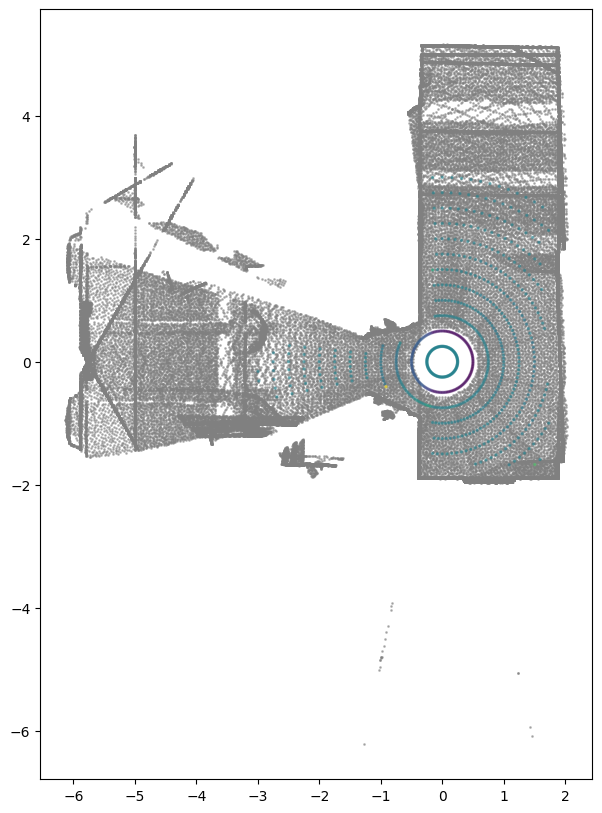

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
number = 12
k = 0
heading = k * 2 * math.pi / number
theta = -(heading - np.pi) / 2 
init_agent_position = np.array(raw_graph_data[cur_scan_id]['nodes'][waypoint_id]) # this is the agent position
camera_height = 0.38 #1.25 # notice I do not think the robot is this tall, but this is the height of the camera
init_camera_position = init_agent_position + np.array([0, camera_height, 0])
init_agent_rotation = np.quaternion(np.cos(theta), 0, np.sin(theta), 0)
init_camera_rotation = init_agent_rotation
all_camera_positions, all_camera_rotations = [], []
all_depths = []
for k in range(number):
    heading = k * 2 * math.pi / number
    theta = -(heading - np.pi) / 2 
    rotation = np.quaternion(np.cos(theta), 0, np.sin(theta), 0)
    obs = sim.get_observations_at(init_agent_position, rotation) # this function need agent position as input not camera position
    all_depths.append(obs['depth'])
    all_camera_positions.append(init_camera_position)
    all_camera_rotations.append(rotation)
    
point_np_sum = []
for v in range(number):
    camera_matrix_T = get_transform_matrices(all_camera_positions[v], all_camera_rotations[v], init_camera_position, init_camera_rotation)
    full_scene_pcd = build_full_scene_pcd(all_depths[v][:,:,0], hfov=90)
    full_scene_pcd.transform(camera_matrix_T)
    points_np = np.asarray(full_scene_pcd.points)
    point_np_sum.append(points_np)
    # ax.scatter(  -points_np[:, 2], -points_np[:, 0],  s=1.0)
    
point_np_sum = np.concatenate(point_np_sum, axis=0)
ax.scatter( point_np_sum[:, 0], point_np_sum[:, 2],  s=1.0, c='grey', alpha=0.5)

num_angles = 120
num_distances = 12
max_dist = 3
angle_resolution = 2 * np.pi / num_angles
dist_resolution = max_dist / num_distances
max_unit_climb = 0.21
robot_height = 0.38  # height of the robot
slopes = np.zeros((num_angles, num_distances))
robot_radius = 0.2
xys = np.zeros((num_angles,  num_distances, 2))
for angle_idx in range(num_angles):
    robot_floor = -robot_height
    for dist_idx in range(num_distances):
        angle = angle_idx * angle_resolution
        dist = (dist_idx + 1) * dist_resolution
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        xys[angle_idx, dist_idx, 0] = x
        xys[angle_idx, dist_idx, 1] = y
        # find all points with in 0.4 m from (x,y) 
        distances = np.sqrt((point_np_sum[:, 0] - x) ** 2 + (point_np_sum[:, 2] - y) ** 2)
        close_points = point_np_sum[distances < robot_radius] # robot_radius this is based on the robot size
        if len(close_points) == 0:
            # no points in this direction at this distance 
            continue
        else:
            # find the maximum allowed height at this distance
            # carmera position is at (0, 0, 0) and the camera height is 0.38
            z_max = robot_floor + robot_height + 0.5 #0.5
            z_min = robot_floor #-robot_height
            lower_points = close_points[(close_points[:, 1] <= z_max)]#&(close_points[:, 1] >= z_min)]
            if len(lower_points) == 0:
                # no points below the maximum height
                continue
            max_height = lower_points[:, 1].max()
            slopes[angle_idx, dist_idx] = max_height - robot_floor
        robot_floor += slopes[angle_idx, dist_idx]
                    
        # ax.scatter(x, y, s=1.0, c='red', alpha=0.5)
# find the first slope in each direction that is larger than the maximum allowed slope
max_slope = 0.25#0.21
valid_slope = np.zeros((num_angles, num_distances))
for angle_idx in range(num_angles):
    for dist_idx in range(num_distances):
        if slopes[angle_idx, dist_idx] > max_slope:# or slopes[angle_idx, dist_idx] < -max_slope:
            valid_slope[angle_idx, dist_idx:] = 1
            break
# ax.scatter(0,0)
ax.scatter(xys[valid_slope==0, 0], xys[valid_slope==0, 1], s=2.0, c=slopes[valid_slope==0], alpha=0.5)
# ax.scatter(xys[valid_slope==0, 0], xys[valid_slope==0, 1], s=2.0, c=slopes[valid_slope==0], alpha=0.5)
# Your data
# cmap = plt.get_cmap('jet')  # or 'coolwarm', 'bwr'
# import matplotlib.colors as mcolors
# # Symmetric normalization centered at zero
# vmax = np.max(np.abs(slopes[valid_slope == 0]))
# norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)
# sc = ax.scatter(
#     xys[valid_slope == 0, 0],
#     xys[valid_slope == 0, 1],
#     s=2.0,
#     c=slopes[valid_slope == 0],
#     cmap=cmap,
#     norm=norm,
#     alpha=0.5
# )

# ax.scatter(xys[66:68, :, 0], xys[66:68, :, 1], s=1.0, c='red', alpha=0.5)

ax.set_aspect('equal', adjustable='box')

In [16]:
slopes[65:68]

array([[ 0.        ,  0.        ,  0.        ,  0.05383578, -0.14324257,
        -0.18616007, -0.209052  , -0.18914855, -0.01033927, -1.0691439 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.21822205, -0.11559973, -0.1601943 ,
        -0.21799488, -0.22749721, -0.18104261, -0.00358258,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.29416975, -0.17422276, -0.17751897,
        -0.21799488, -0.25155443, -0.75257287,  0.        ,  0.        ,
         0.        ,  0.        ]])

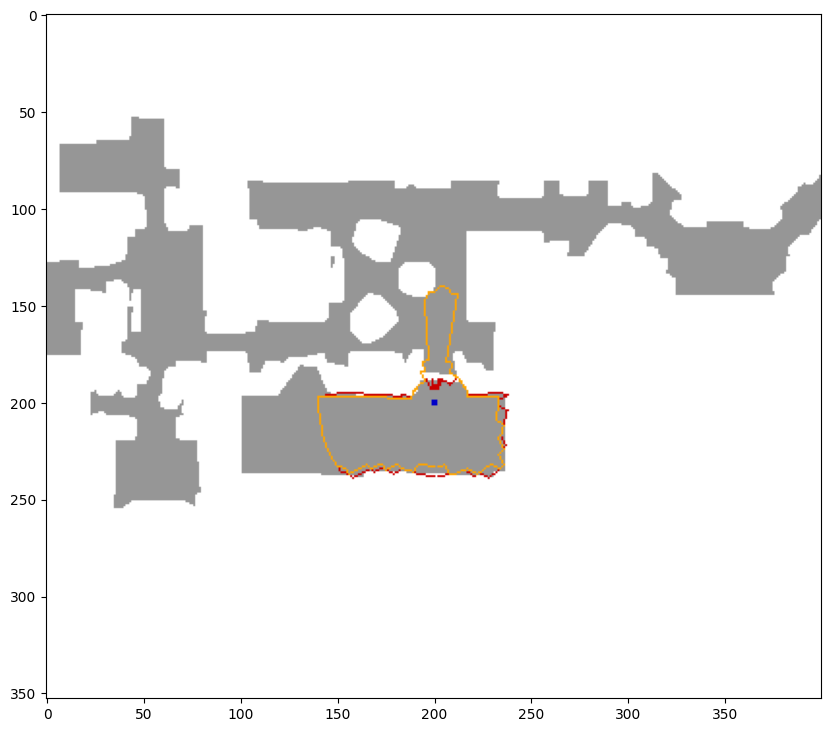

In [8]:
cur_obstacle = obstacle[0].cpu().numpy()
cur_source_pos = source_pos[0]
current_heading = 0.0
obstacle_radial = draw.get_obstacles_from_radial_map(cur_obstacle, 120, 12)
last_pos_index = None

node_height = raw_graph_data[cur_scan_id]['nodes'][waypoint_id][1]
top_down_map = draw.get_top_down_map(sim, base_height=node_height)
source_pos_index = habitat_maps.to_grid(cur_source_pos[1], cur_source_pos[0], top_down_map.shape[0:2], sim)
draw.draw_source_new(top_down_map, cur_source_pos, 0.05, sim)
for r, theta in obstacle_radial:
    pos = draw._rtheta_to_global_coordinates(r, theta, cur_source_pos, current_heading)
    pos_index = habitat_maps.to_grid(pos[1], pos[0], top_down_map.shape[0:2], sim)
    if last_pos_index != None:
        draw.drawline(top_down_map, [last_pos_index[1], last_pos_index[0]], [pos_index[1], pos_index[0]], thickness=1, style="filled", color=6 ,gap=1)
    #draw.draw_obstacle_new(top_down_map_2, pos, 0.05, sim)
    last_pos_index = pos_index

current_heading = 0.0  
obs_pred_radial = draw.get_obstacles_from_radial_map(valid_slope, 120, 12)
last_pos_index = None
for r, theta in obs_pred_radial:
    pos = draw._rtheta_to_global_coordinates(r, theta, cur_source_pos, current_heading)
    pos_index = habitat_maps.to_grid(pos[1], pos[0], top_down_map.shape[0:2], sim)
    if last_pos_index != None:
        draw.drawline(top_down_map, [last_pos_index[1], last_pos_index[0]], [pos_index[1], pos_index[0]], thickness=1, style="filled", color=13 ,gap=1)
    #draw.draw_obstacle_new(top_down_map_2, pos, 0.05, sim)
    last_pos_index = pos_index

color_map = draw.colorize_topdown_map(top_down_map)
crop_image = draw.crop_around_point(color_map, source_pos_index[0], source_pos_index[1], padding=200)
# sim.close()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(crop_image)

In [ ]:
num_angles = 120
num_distances = 12
max_dist = 3
angle_resolution = 2 * np.pi / num_angles
dist_resolution = max_dist / num_distances

for angle_idx in range(num_angles):
    for dist_idx in range(num_distances):
        angle = angle_idx * angle_resolution
        dist = (dist_idx + 1) * dist_resolution
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        

In [9]:
agent_state = sim.get_agent(0).get_state()
depth_camera_position = agent_state.sensor_states["depth"].position

In [10]:
agent_state.position

array([13.55902  ,  0.12711  ,  1.6699859], dtype=float32)

In [11]:
depth_camera_position

array([13.55902  ,  1.00711  ,  1.6699859], dtype=float32)

In [ ]:
num_angles = 120
num_distances = 12
max_dist = 3
angle_resolution = 2 * np.pi / num_angles
dist_resolution = max_dist / num_distances
max_unit_climb = 0.21
robot_height = 0.38  # height of the robot
slopes = np.zeros((num_angles, num_distances))
for angle_idx in range(num_angles):
    robot_floor = -robot_height
    for dist_idx in range(num_distances):
        angle = angle_idx * angle_resolution
        dist = (dist_idx + 1) * dist_resolution
        x = dist * np.cos(angle)
        y = dist * np.sin(angle)
        # find all points with in 0.4 m from (x,y) 
        distances = np.sqrt((points_np[:, 0] - x) ** 2 + (points_np[:, 2] - y) ** 2)
        close_points = points_np[distances < 0.2] # 0.2 this is based on the robot size
        if len(close_points) == 0:
            # no points in this direction at this distance 
            continue
        else:
            # find the maximum allowed height at this distance
            # carmera position is at (0, 0, 0) and the camera height is 0.38
            z_max = robot_floor + max_unit_climb
            lower_points = close_points[close_points[:, 1] < z_max]
            higher_points = close_points[close_points[:, 1] >= z_max]
            if len(lower_points) == 0:
                min_higher_point = higher_points[:, 1].min()
                if min_higher_point < robot_floor + robot_height + 0.25:
                    slopes[angle_idx, dist_idx] = min_higher_point - robot_floor
                else:
                    # the ceiling is high enough 
                    slopes[angle_idx, dist_idx] = 0
            else:
                max_lower_point = lower_points[:, 1].max()
                if len(higher_points) == 0:
                    # ceiling is very high
                    slopes[angle_idx, dist_idx] = max_lower_point - robot_floor
                else:
                    min_higher_point = higher_points[:, 1].min()
                    if min_higher_point < robot_floor + robot_height + 0.25:
                        # an obstacle is blocking the way
                        slopes[angle_idx, dist_idx] = min_higher_point - robot_floor
                    else:
                        # the ceiling is high enough 
                        slopes[angle_idx, dist_idx] = max_lower_point - robot_floor
        robot_floor += slopes[angle_idx, dist_idx]
                    
        ax.scatter(x, y, s=1.0, c='red', alpha=0.5)